Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Piotr Durniat"

---

# SimCLR
W poprzednim zeszycie rozważana była estymacja rozkładu z wykorzystaniem NCE. InfoNCE jest jego rozszerzeniem do problemu wieloklasowego i zostało wykorzystane w licznych metodach kontrastowego uczenia samonadzorowanego. W niniejszym zeszycie skupimy się na metodzie `SimCLR` [(Chen et al., 2020)](https://arxiv.org/abs/2002.05709). **Należy się dokładnie zapoznać z ideą i zasadą działania SimCLR** (wykorzystując materiały z wykładu oraz publikacje, bądź inne materiały dostępne w sieci). 


W niniejszym zeszycie należy wykonać zadania z zakresu implementacji metody `SimCLR` oraz badania jej hiperparametrów. Model oraz trenowanie zaimplementowano z wykorzystaniem `pytorch_lightning`. Żeby zrozumieć dobrze implementacje, należy zapoznać się z klasą bazową `SSLBase` i ewaluacją na zadaniu docelowym, która została w tej klasie zaimplementowana.

In [2]:
%load_ext tensorboard

In [3]:
import copy

import torch
from lightning_fabric import seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
from lightning import Trainer
from torch import nn, Tensor
from torch.nn import functional as F

from src.data import VisionDatamodule
from src.ssl_base import SSLBase
from src.networks import SmallConvnet, MLP
from src.augmentations import get_default_aug

# Zbiór danych
Do uczenia `SimCLR` wykorzystamy wypróbkowany podzbiór zbioru MNIST. Warto zaznaczyć, że jest to wybór podyktowany tylko i wyłącznie ograniczeniami w zasobach obliczeniowych. W rzeczywistości, aby otrzymać konkluzywne i rzetelne wyniki, należałoby skorzystać co najmniej ze zbioru `CIFAR-10` oraz znacznie większego modelu kodera, np. `ResNet`. Jednak do celów dydaktycznych skorzystamy z mniejszego zbioru oraz odpowiednio mniejszego kodera.

In [4]:
# define parameters
DATA_DIR = "./data"
OUT_DIR = "./data/output/sim_clr"
BATCH_SIZE = 512
NUM_WORKERS = 0
NUM_SAMPLES_PER_CLASS = 300

In [5]:
datamodule = VisionDatamodule(
    root_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    num_samples_per_class=NUM_SAMPLES_PER_CLASS,
)
datamodule.prepare_data()
datamodule.setup()

# Zadanie 2.1 Implementacja modelu SimCLR (2.0 pkt)
W poniższej komórce znajduje się częściowa implementacja modelu `SimCLR`. Uzupełnij brakujące implementacje funkcji:
* `forward` (1.0 pkt) - implementuje przejście w przód modelu (augmentacje do dwóch widoków, forward widoków przez `encoder` oraz `projector`), zwraca parę embeddingów.
* `info_nce_loss` (1.0 pkt) - funkcja straty modelu `SimCLR`:
$$
\ell_{i, j}=-\log \frac{\exp \left(\operatorname{sim}\left(z_i, z_j\right) / \tau\right)}{\sum_{k=1}^{2 N} \mathbb{1}_{[k \neq i]} \exp \left(\operatorname{sim}\left(z_i, z_k\right) / \tau\right)},
$$
gdzie $\operatorname{sim}$ - podobieńśtwo cosinusowe, $\tau$ - parametr temperatury.

Ponadto:
* Wykorzystuj metody z torch'a, unikaj pythonowych pętli.
* Przeanalizuj dokładnie pozostałe elementy implementacji.
* Uruchom uczenie i przeanalizuj wyniki.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class SimCLRModel(SSLBase):

    temp: float
    encoder: nn.Module
    decoder: nn.Module

    def __init__(
        self,
        learning_rate: float,
        weight_decay: float,
        temp: float,
        out_channels: int = 10,
    ):
        super().__init__(
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            out_channels=out_channels,
        )

        # Initialize online network
        self.encoder = SmallConvnet()
        self.projector = MLP(84, 84, 84, plain_last=True)

        self.aug_1 = get_default_aug()
        self.aug_2 = get_default_aug()

        self.temp = temp

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        # TU WPISZ KOD

        z_i = self.projector(self.encoder(self.aug_1(x)))
        z_j = self.projector(self.encoder(self.aug_2(x)))
        return z_i, z_j

    def forward_repr(self, x: Tensor) -> Tensor:
        return self.encoder(x)

    def training_step(self, batch: Tensor, batch_idx: int) -> Tensor:
        x, _ = batch
        z_i, z_j = self.forward(x)
        loss = self.info_nce_loss(z_i=z_i, z_j=z_j)

        self.log("train/loss", loss, prog_bar=True)

        return loss

    def info_nce_loss(self, z_i: Tensor, z_j: Tensor) -> Tensor:

        # z_i and z_j are [512, 84]
        batch_size = z_i.shape[0]

        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(
            representations.unsqueeze(1), representations.unsqueeze(0), dim=2
        )

        # Compute l_{i,j} only for positives paris (diagonal)
        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temp)

        negatives_mask = (
            ~torch.eye(batch_size * 2, batch_size * 2, dtype=bool).to(z_i.device)
        ).float()

        denominator = negatives_mask * torch.exp(similarity_matrix / self.temp)

        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * batch_size)

        return loss

In [7]:
%tensorboard --logdir "./data/output/sim_clr"

In [8]:
# define hyperparameters
TEMPERATURE = 0.07
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 75
# EPOCHS = 5

ACCELERATOR = "cuda" if torch.cuda.is_available() else "cpu"

seed_everything(42)
model = SimCLRModel(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    temp=TEMPERATURE,
)
logger = TensorBoardLogger(save_dir=OUT_DIR, default_hp_metric=False)
trainer = Trainer(
    default_root_dir=OUT_DIR,
    max_epochs=EPOCHS,
    logger=logger,
    accelerator=ACCELERATOR,
    num_sanity_val_steps=0,
    log_every_n_steps=10,
)

trainer.fit(model, datamodule)
trainer.test(model, datamodule)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | SmallConvnet | 43.6 K
1 | projector | MLP          | 14.4 K
2 | aug_1     | Sequential   | 0     
3 | aug_2     | Sequential   | 0     
-------------------------------------------
58.0 K    Trainable params
0         Non-trainable params
58.0 K    Total params
0.232     Total estimated model params size (MB)
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packa

Epoch 4: 100%|██████████| 5/5 [00:11<00:00,  0.43it/s, v_num=7, train/loss=0.892]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 5/5 [00:11<00:00,  0.43it/s, v_num=7, train/loss=0.892]


/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.7824334502220154
         test/f1            0.7768892645835876
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/accuracy': 0.7824334502220154, 'test/f1': 0.7768892645835876}]

# Zadanie 2.2 Badanie `batch_size` (1 pkt)
Jako jedną z głównych wad metod kontrastowych podaje się wymaganie na stosowanie dużych batch'y. W tym zadaniu:
* Sprawdź co najmniej 3 wielkości batch'a
* Idelanie będzie wykonać 3-5 powtórzeń dla każdej wartości parametru, ale jeśli ograniczają Cię zasoby wystarczy 1
* Z każdym kolejnym uruchominiem uczenia ustawiaj na nowo seed
* Wynik na zbiorze testowym wylicz metodą `trainer.test(...)`, a na podstawie wyników sporządź wykres
* Co zaobserwowałeś? Wyjaśnij otrzymaną zależność.

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | SmallConvnet | 43.6 K
1 | projector | MLP          | 14.4 K
2 | aug_1     | Sequential   | 0     
3 | aug_2     | Sequential   | 0     
-------------------------------------------
58.0 K    Trainable params
0         Non-trainable params
58.0 K    Total params
0.232     Total estimated model params size (MB)
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packa

Epoch 1: 100%|██████████| 10/10 [00:11<00:00,  0.88it/s, v_num=23, train/loss=2.220]

/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 40/? [00:03<00:00, 10.01it/s]

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy          0.780520498752594
         test/f1            0.7747006416320801
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test/accuracy': 0.780520498752594, 'test/f1': 0.7747006416320801}]



  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | SmallConvnet | 43.6 K
1 | projector | MLP          | 14.4 K
2 | aug_1     | Sequential   | 0     
3 | aug_2     | Sequential   | 0     
-------------------------------------------
58.0 K    Trainable params
0         Non-trainable params
58.0 K    Total params
0.232     Total estimated model params size (MB)
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower va

Epoch 0:  60%|██████    | 3/5 [00:08<00:05,  0.34it/s, v_num=24, train/loss=1.180]

/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.7348148822784424
         test/f1            0.7287061214447021
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test/accuracy': 0.7348148822784424, 'test/f1': 0.7287061214447021}]



  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | SmallConvnet | 43.6 K
1 | projector | MLP          | 14.4 K
2 | aug_1     | Sequential   | 0     
3 | aug_2     | Sequential   | 0     
-------------------------------------------
58.0 K    Trainable params
0         Non-trainable params
58.0 K    Total params
0.232     Total estimated model params size (MB)
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower va

Epoch 1:   0%|          | 0/3 [00:00<?, ?it/s, v_num=25, train/loss=1.220]        

/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.7437306642532349
         test/f1            0.7379434108734131
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test/accuracy': 0.7437306642532349, 'test/f1': 0.7379434108734131}]


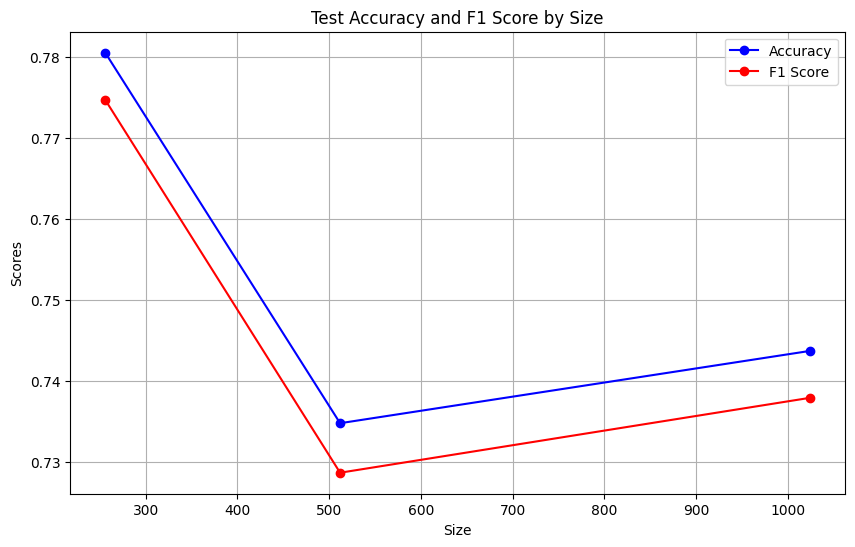

In [16]:
import matplotlib.pyplot as plt


# TU WPISZ KOD
def test():
    # EPOCHS = 1
    EPOCHS = 75

    results = {}
    batch_sizes = [256, 512, 1024]
    for batch_size in batch_sizes:
        datamodule = VisionDatamodule(
            root_dir=DATA_DIR,
            batch_size=batch_size,
            num_workers=NUM_WORKERS,
            num_samples_per_class=NUM_SAMPLES_PER_CLASS,
        )
        datamodule.prepare_data()
        datamodule.setup()

        ACCELERATOR = "cuda" if torch.cuda.is_available() else "cpu"

        seed_everything(42)
        model = SimCLRModel(
            learning_rate=LEARNING_RATE,
            weight_decay=WEIGHT_DECAY,
            temp=TEMPERATURE,
        )
        logger = TensorBoardLogger(save_dir=OUT_DIR, default_hp_metric=False)
        trainer = Trainer(
            default_root_dir=OUT_DIR,
            max_epochs=EPOCHS,
            logger=logger,
            accelerator=ACCELERATOR,
            num_sanity_val_steps=0,
            log_every_n_steps=10,
        )

        trainer.fit(model, datamodule)
        res = trainer.test(model, datamodule)
        print(res)
        # [{'test/accuracy': 0.769562840461731, 'test/f1': 0.7648827433586121}]
        results[batch_size] = res[0]
    return results


def chart_res(results):
    sizes = list(results.keys())
    accuracies = [results[size]["test/accuracy"] for size in sizes]
    f1_scores = [results[size]["test/f1"] for size in sizes]

    plt.figure(figsize=(10, 6))
    plt.plot(sizes, accuracies, marker="o", linestyle="-", color="b", label="Accuracy")
    plt.plot(sizes, f1_scores, marker="o", linestyle="-", color="r", label="F1 Score")

    plt.xlabel("Size")
    plt.ylabel("Scores")
    plt.title("Test Accuracy and F1 Score by Size")

    plt.grid(True)
    plt.legend()
    plt.show()


results = test()
chart_res(results)